In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd
import skforecast

print(skforecast.__version__)

c:\Users\jaesc2\GitHub\skforecast
0.19.0


In [2]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from skforecast.exceptions import MissingValuesWarning
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import make_pipeline
from skforecast.preprocessing import RollingFeaturesClassification
from skforecast.recursive import ForecasterRecursiveClassifier, ForecasterRecursive
from skforecast.model_selection._split import TimeSeriesFold
from skforecast.model_selection._validation import _backtesting_forecaster

from skforecast.recursive.tests.tests_forecaster_recursive_classifier.fixtures_forecaster_recursive_classifier import y, y_dt
from skforecast.recursive.tests.tests_forecaster_recursive_classifier.fixtures_forecaster_recursive_classifier import exog, exog_dt, exog_predict, exog_dt_predict

In [23]:
data = pd.read_csv(
    r"C:\Users\jaesc2\Downloads\synthetic_ts_classification.csv",
    index_col = 0,
    parse_dates=True
)
data = data.asfreq('D')
data = data.sort_index()
data['promo'] = data['promo'].astype('category')
data['dow'] = data['dow'].astype('category')

display(data.head())
print(data.index)        # verás que es un DatetimeIndex
print(data.dtypes)       # tipos de cada columna
print(data.isna().sum().sum())

,y,temp,rain,promo,dow,month_sin,month_cos
2020-01-01,mid,15.761793,0.000000,0,2,0.000000,1.000000
2020-01-02,mid,12.572055,3.045914,0,3,0.017202,0.999852
2020-01-03,peak,17.220109,0.000000,0,4,0.034398,0.999408
2020-01-04,peak,17.867255,0.000000,0,5,0.051584,0.998669
2020-01-05,low,10.809966,15.321044,0,6,0.068755,0.997634


DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08',
               '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12',
               '2023-04-13', '2023-04-14'],
              dtype='datetime64[ns]', length=1200, freq='D')
y              object
temp          float64
rain          float64
promo        category
dow          category
month_sin     float64
month_cos     float64
dtype: object
0


In [24]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

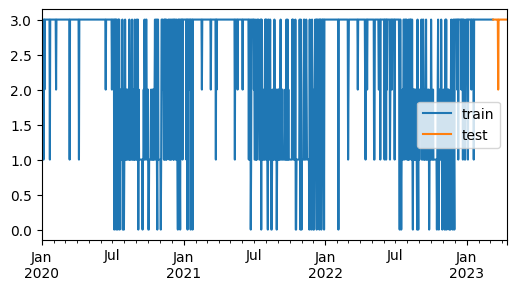

In [25]:
# Plot
# ==============================================================================
unique_classes = np.unique(data['y'])
n_classes = len(unique_classes)
label_encoder_ = LabelEncoder()
y_train_plot = pd.Series(label_encoder_.fit_transform(data_train['y']), index=data_train.index)
y_test_plot = pd.Series(label_encoder_.transform(data_test['y']), index=data_test.index)

fig, ax = plt.subplots(figsize=(6, 3))
y_train_plot.plot(ax=ax, label='train')
y_test_plot.plot(ax=ax, label='test')
ax.legend();

# `y` as floats -> no necesito encoding -> pero regressor LGBM -> cateogrical porque es 'auto' 

In [30]:
# Create and fit forecaster
# ==============================================================================
stats = [
    'proportion', 'mode', 'entropy', 'n_changes', 'n_unique'
]

rolling = RollingFeaturesClassification(
    stats=stats, 
    window_sizes=3,
    # features_names=[f"feature_{i}" for i in range(len(stats))]
)

regressor = CalibratedClassifierCV(LGBMClassifier(random_state=123, verbose=-1))
forecaster = ForecasterRecursiveClassifier(
                 regressor         = regressor,
                 lags              = 3,
                 window_features   = rolling,
                 features_encoding = 'categorical', 
             )

X_train, y_train = forecaster.create_train_X_y(
    y=data_train['y'], exog=data_train.drop(columns=['y']), encoded=True
)
forecaster.fit(
    y=data_train['y'], exog=data_train.drop(columns=['y'])
)

In [31]:
forecaster.regressor

CalibratedClassifierCV(estimator=LGBMClassifier(random_state=123, verbose=-1))

In [35]:
forecaster.predict(steps=len(data_test), exog=data_test.drop(columns=['y']))

2023-03-10    peak
2023-03-11    peak
2023-03-12    peak
2023-03-13    peak
2023-03-14    peak
2023-03-15    peak
2023-03-16    peak
2023-03-17    peak
2023-03-18    peak
2023-03-19    peak
2023-03-20    peak
2023-03-21    peak
2023-03-22    peak
2023-03-23    peak
2023-03-24    peak
2023-03-25    peak
2023-03-26    peak
2023-03-27    peak
2023-03-28    peak
2023-03-29    peak
2023-03-30    peak
2023-03-31    peak
2023-04-01    peak
2023-04-02    peak
2023-04-03    peak
2023-04-04    peak
2023-04-05    peak
2023-04-06    peak
2023-04-07    peak
2023-04-08    peak
2023-04-09    peak
2023-04-10    peak
2023-04-11    peak
2023-04-12    peak
2023-04-13    peak
2023-04-14    peak
Freq: D, Name: pred, dtype: object

In [36]:
forecaster.predict_proba(steps=len(data_test), exog=data_test.drop(columns=['y']))

,high_proba,low_proba,mid_proba,peak_proba
2023-03-10,0.039451,0.080474,0.079984,0.800091
2023-03-11,0.039445,0.080531,0.079917,0.800108
2023-03-12,0.039443,0.080462,0.079902,0.800193
2023-03-13,0.044304,0.182684,0.089335,0.683677
2023-03-14,0.039473,0.080511,0.080407,0.799610
2023-03-15,0.039483,0.081075,0.080189,0.799253
2023-03-16,0.039683,0.088854,0.080923,0.790540
2023-03-17,0.039522,0.081882,0.080438,0.798159
2023-03-18,0.039460,0.080834,0.079982,0.799724
2023-03-19,0.039448,0.080473,0.079968,0.800112


In [7]:
X_train.head(2)

,lag_1,lag_2,lag_3,roll_proportion_3_class_0,roll_proportion_3_class_1,roll_proportion_3_class_2,roll_proportion_3_class_3,roll_mode_3,roll_entropy_3,roll_n_changes_3,roll_n_unique_3,temp,rain,promo,dow,month_sin,month_cos
2020-01-04,3,2,2,0.0,0.0,0.666667,0.333333,2.0,0.918296,1.0,2.0,17.867255,0.000000,0,5,0.051584,0.998669
2020-01-05,3,3,2,0.0,0.0,0.333333,0.666667,3.0,0.918296,1.0,2.0,10.809966,15.321044,0,6,0.068755,0.997634


In [8]:
data_train['y'].head(5)

2020-01-01     mid
2020-01-02     mid
2020-01-03    peak
2020-01-04    peak
2020-01-05     low
Freq: D, Name: y, dtype: object

In [9]:
forecaster.classes_

['high', 'low', 'mid', 'peak']

In [10]:
forecaster.regressor.classes_

array([0, 1, 2, 3])

In [11]:
forecaster.encoding_mapping_

{'high': 0, 'low': 1, 'mid': 2, 'peak': 3}

In [12]:
data_train.head(10)

,y,temp,rain,promo,dow,month_sin,month_cos
2020-01-01,mid,15.761793,0.000000,0,2,0.000000,1.000000
2020-01-02,mid,12.572055,3.045914,0,3,0.017202,0.999852
2020-01-03,peak,17.220109,0.000000,0,4,0.034398,0.999408
2020-01-04,peak,17.867255,0.000000,0,5,0.051584,0.998669
2020-01-05,low,10.809966,15.321044,0,6,0.068755,0.997634
2020-01-06,low,12.603612,5.231499,0,0,0.085906,0.996303
2020-01-07,peak,16.349915,0.931350,0,1,0.103031,0.994678
2020-01-08,mid,15.410655,0.000000,0,2,0.120126,0.992759
2020-01-09,peak,16.329851,0.000000,0,3,0.137185,0.990545
2020-01-10,peak,14.409431,0.000000,0,4,0.154204,0.988039


In [13]:
forecaster.encoding_mapping_

{'high': 0, 'low': 1, 'mid': 2, 'peak': 3}

In [29]:
forecaster.last_window_

,y
2023-03-07,4
2023-03-08,5
2023-03-09,6


In [31]:
forecaster._create_predict_inputs(steps=3,)

(array([0, 1, 2]),
 None,
 DatetimeIndex(['2023-03-10', '2023-03-11', '2023-03-12'], dtype='datetime64[ns]', freq='D'),
 3)

In [ ]:
last_window = forecaster.last_window_.copy()


In [62]:
(X_train['lag_1'].cat.codes == X_train['lag_1']).all()

np.True_

In [18]:
pd.Series(['air', 'car', 'bus'], dtype='category')

0    air
1    car
2    bus
dtype: category
Categories (3, object): ['air', 'bus', 'car']

In [19]:
y = pd.Series(['air', 'car', 'bus'], dtype='object')
y

0    air
1    car
2    bus
dtype: object

In [27]:
y = pd.Series(['air', 'car', 'bus'], dtype='object')
y = pd.Categorical(y, categories=['air', 'car', 'bus'])

print(y.categories)
print(y.codes)
print(y)

Index(['air', 'car', 'bus'], dtype='object')
[0 1 2]
['air', 'car', 'bus']
Categories (3, object): ['air', 'car', 'bus']


In [31]:
y = pd.Series(['bus', 'car', 'air'], dtype='object')
y = pd.Categorical(y, categories=['car', 'air', 'bus'])

print(y.categories)
print(y.codes)

Index(['car', 'air', 'bus'], dtype='object')
[2 0 1]


In [17]:
y = pd.Categorical(['bus', 'air', 'car', 'air'], ordered=False)

print(y.categories)
print(y.codes)

Index(['air', 'bus', 'car'], dtype='object')
[1 0 2 0]


In [24]:
y = pd.Series(pd.Categorical(['bus', 'air', 'car', 'air'], ordered=False))

print(y.cat.categories)
print(y.cat.codes)

Index(['air', 'bus', 'car'], dtype='object')
0    1
1    0
2    2
3    0
dtype: int8


In [16]:
from sklearn.preprocessing import OrdinalEncoder

variable_1 = pd.Series(['bus', 'air', 'car', 'air'], name='y')
encoder = OrdinalEncoder(
            categories = 'auto',
            dtype      = int
        ).set_output(transform='pandas')
variable_1_encoded = encoder.fit_transform(variable_1.to_frame())
variable_1_encoded

,y
0,1
1,0
2,2
3,0


In [19]:
variable_2 = pd.Series(['bus', 'air', 'boat', 'air'], name='y')
encoder.transform(variable_2.to_frame())

ValueError: Found unknown categories ['boat'] in column 0 during transform

In [17]:
encoding_mapping_ = {}
for i, code in enumerate(encoder.categories_[0]):
    encoding_mapping_[code] = i
encoding_mapping_

{'air': 0, 'bus': 1, 'car': 2}

In [18]:
encoder.categories_[0]

array(['air', 'bus', 'car'], dtype=object)

In [29]:
y = pd.Series(
        pd.Categorical(
            ['bus', 'air', 'car', 'air'], 
            ordered=False,
            categories=encoder.categories_[0]
        )
    )
y

0    bus
1    air
2    car
3    air
dtype: category
Categories (3, object): ['air', 'bus', 'car']

In [38]:
encoding_mapping_.values()

dict_values([0, 1, 2])

In [40]:
lag_1 = pd.Series(np.array([1, 0, 2]))
lag_1 = pd.Categorical(
            values     = lag_1,
            categories = encoding_mapping_.values(),
            ordered    = False
        )

print(lag_1)
print(lag_1.codes)
print(lag_1.categories)

[1, 0, 2]
Categories (3, int64): [0, 1, 2]
[1 0 2]
Index([0, 1, 2], dtype='int64')


In [41]:
lag_1 = pd.Series(np.array([1, 2]))
lag_1 = pd.Categorical(
            values     = lag_1,
            categories = encoding_mapping_.values(),
            ordered    = False
        )

print(lag_1)
print(lag_1.codes)
print(lag_1.categories)

[1, 2]
Categories (3, int64): [0, 1, 2]
[1 2]
Index([0, 1, 2], dtype='int64')


In [42]:
lag_1 = pd.Series(np.array([2, 1]))
lag_1 = pd.Categorical(
            values     = lag_1,
            categories = encoding_mapping_.values(),
            ordered    = False
        )

print(lag_1)
print(lag_1.codes)
print(lag_1.categories)

[2, 1]
Categories (3, int64): [0, 1, 2]
[2 1]
Index([0, 1, 2], dtype='int64')


In [43]:
lag_1 = pd.Series(np.array([2, 1]))
lag_1 = pd.Categorical(
            values     = lag_1,
            categories = np.array([2, 1]),
            ordered    = False
        )

print(lag_1)
print(lag_1.codes)
print(lag_1.categories)

[2, 1]
Categories (2, int64): [2, 1]
[0 1]
Index([2, 1], dtype='int64')


In [44]:
from sklearn.preprocessing import OrdinalEncoder

variable_1 = pd.Series([1.0, 0.0, 2.0], name='y')
encoder = OrdinalEncoder(
            categories = 'auto',
            dtype      = int
        ).set_output(transform='pandas')
variable_1_encoded = encoder.fit_transform(variable_1.to_frame())
variable_1_encoded

,y
0,1
1,0
2,2


In [45]:
encoding_mapping_ = {}
for i, code in enumerate(encoder.categories_[0]):
    encoding_mapping_[code] = i
encoding_mapping_

{np.float64(0.0): 0, np.float64(1.0): 1, np.float64(2.0): 2}

In [46]:
lag_1 = pd.Series(np.array([1., 0., 2.]))
lag_1 = pd.Categorical(
            values     = lag_1,
            categories = encoding_mapping_.values(),
            ordered    = False
        )

print(lag_1)
print(lag_1.codes)
print(lag_1.categories)

[1, 0, 2]
Categories (3, int64): [0, 1, 2]
[1 0 2]
Index([0, 1, 2], dtype='int64')


In [47]:
lag_1 = pd.Series(np.array([0., 1., 2.]))
lag_1 = pd.Categorical(
            values     = lag_1,
            categories = encoding_mapping_.values(),
            ordered    = False
        )

print(lag_1)
print(lag_1.codes)
print(lag_1.categories)

[0, 1, 2]
Categories (3, int64): [0, 1, 2]
[0 1 2]
Index([0, 1, 2], dtype='int64')


In [19]:
dict(enumerate(y.categories))

{0: 'air', 1: 'bus', 2: 'car'}

In [37]:
variable_1 = pd.Series(["a", "b", "c", "a"], dtype="category")
variable_2 = pd.Series(['b', 'c', 'b'], dtype="category")
variable_2 = pd.Series(['c', 'c', 'd'], dtype="category")

# variable_1 = pd.Series([1, 2, 1, 3], dtype="category")
# variable_2 = pd.Series(['b', 'c', 'b'], dtype="category")
# variable_2 = pd.Series([2, 3, 3], dtype="category")

variable_2 = pd.Series(pd.Categorical(
                variable_2,
                categories=variable_1.cat.categories,
                ordered=False
            ))

mapa_variable_1 = dict(enumerate(variable_1.cat.categories))
mapa_variable_2 = dict(enumerate(variable_2.cat.categories))
print(mapa_variable_1)
print(mapa_variable_2)
print(variable_2)
print(variable_2.cat.codes)

{0: 'a', 1: 'b', 2: 'c'}
{0: 'a', 1: 'b', 2: 'c'}
0      c
1      c
2    NaN
dtype: category
Categories (3, object): ['a', 'b', 'c']
0    2
1    2
2   -1
dtype: int8


In [58]:
from sklearn.preprocessing import OrdinalEncoder

variable_1 = pd.Series(["a", "b", "c", "a"], name='y')
encoder = OrdinalEncoder(
            categories = 'auto',
            dtype      = int
        ).set_output(transform='pandas')
variable_1_encoded = encoder.fit_transform(variable_1.to_frame())
variable_1_encoded

,y
0,0
1,1
2,2
3,0


In [75]:
dtype = pd.CategoricalDtype(['a', 'b'], ordered=False)

pd.Categorical.from_codes(codes=[0, 1, 0, 1], dtype=dtype)

['a', 'b', 'a', 'b']
Categories (2, object): ['a', 'b']

In [59]:
variable_1_encoded['y'] = variable_1_encoded['y'].astype('category')
variable_1_encoded

,y
0,0
1,1
2,2
3,0


In [61]:
variable_1_encoded['y'].cat.codes

0    0
1    1
2    2
3    0
dtype: int8

In [41]:
encoding_mapping_ = {}
for i, code in enumerate(encoder.categories_[0]):
    encoding_mapping_[code] = i
encoding_mapping_

{'a': 0, 'b': 1, 'c': 2}

In [52]:
encoder.categories_[0]

array(['a', 'b', 'c'], dtype=object)

In [47]:
variable_1_encoded

,y
0,0
1,1
2,2
3,0


In [54]:
pd.Categorical(
    values     = variable_1_encoded['y'],
    categories = encoding_mapping_.values(),
    ordered    = False
)

[0, 1, 2, 0]
Categories (3, int64): [0, 1, 2]

In [56]:
variable_2 = pd.Series(["b", "c", "b"], name='y')
variable_2_encoded = encoder.transform(variable_2.to_frame())
variable_2_encoded

,y
0,1
1,2
2,1


In [57]:
pd.Categorical(
    values     = variable_2_encoded['y'],
    categories = encoding_mapping_.values(),
    ordered    = False
)

[1, 2, 1]
Categories (3, int64): [0, 1, 2]

## Entradas

1. `y` as floats -> no necesito encoding -> pero regressor LGBM es auto -> transformar a categorical porque es 'auto' -> extraer los encodings como el multiseries -> crear lags -> transformar lags a categorical.

2. `y` as strings -> transformar a categorical -> extraer los encodings como el multiseries -> crear lags -> transformar lags a categorical.



In [62]:
variable_3 = pd.Series([1, 2, 1], name='y').to_frame()

In [66]:
y_cat = pd.Categorical(
    values     = variable_3['y'],
    categories = encoding_mapping_.values(),
    ordered    = False
)
y_cat

[1, 2, 1]
Categories (3, int64): [0, 1, 2]

In [12]:
pd.Categorical(
    values     = np.array([2, 3, 1]),
    ordered    = False
)

[2, 3, 1]
Categories (3, int64): [1, 2, 3]

In [13]:
pd.Categorical(
    values     = np.array([2, 3, 1]),
    ordered    = True
)

[2, 3, 1]
Categories (3, int64): [1 < 2 < 3]

In [67]:
y_cat.codes

array([1, 2, 1], dtype=int8)

In [69]:
np.testing.assert_array_equal(y_cat.codes, y_cat.to_numpy())

In [12]:
y_train

2020-01-04    3
2020-01-05    1
2020-01-06    1
2020-01-07    3
2020-01-08    2
             ..
2023-03-05    3
2023-03-06    3
2023-03-07    3
2023-03-08    3
2023-03-09    3
Freq: D, Name: y, Length: 1161, dtype: int64

In [74]:
# Print the features considered as categorical by the forecaster
# ==============================================================================
regressor = forecaster.regressor
cat_index = regressor.booster_.params.get('categorical_column')
if cat_index is not None:
    features_in_model = regressor.booster_.feature_name()
    cat_features_in_model = [features_in_model[i] for i in cat_index]
    
cat_features_in_model

['lag_1', 'lag_2', 'lag_3', 'promo', 'dow']

In [75]:
forecaster.label_encoder_.classes_

array(['high', 'low', 'mid', 'peak'], dtype=object)

In [78]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=36, exog=data_test.drop(columns=['y']))
predictions.head(3)

2023-03-10    3.0
2023-03-11    3.0
2023-03-12    3.0
Freq: D, Name: pred, dtype: float64

In [78]:
y_values = np.array([1.0, 2.0, 3.0, 4.5, 5.1])
not_allowed = np.mod(y_values, 1) != 0
print(not_allowed)
if np.any(not_allowed):
    bad = y_values[not_allowed]
    examples = ", ".join(map(str, np.unique(bad)[:5]))
    raise ValueError(
        "Invalid target for classification: targets must be discrete class labels "
        "(e.g., integers or strings). Received float dtype "
        f"{y_values.dtype} with non-integer values (e.g., {examples}). "
        "If this is a regression problem, use a regression estimator instead. "
        "If labels are meant to be classes, convert them to integers or categories, "
        "e.g., `y = np.round(y).astype(int)` if values should be integers, or map "
        "the floats to class codes explicitly."
    )

[False False False  True  True]


ValueError: Invalid target for classification: targets must be discrete class labels (e.g., integers or strings). Received float dtype float64 with non-integer values (e.g., 4.5, 5.1). If this is a regression problem, use a regression estimator instead. If labels are meant to be classes, convert them to integers or categories, e.g., `y = np.round(y).astype(int)` if values should be integers, or map the floats to class codes explicitly.

In [1]:
d = {
    1.0: 'air'
}


In [2]:
d[1]

'air'

In [ ]:
1.0 -> 1

In [29]:
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
X = pd.DataFrame(
        pd.Categorical(
            values     = np.round(X[:, 0]).flatten(),
            categories = np.unique(np.round(X[:, 0])),
            ordered    = False
        ),
        columns = ['feature_1']
    )
clf = HistGradientBoostingClassifier(max_iter=10).fit(X, y)
clf.score(X, y)

0.6533333333333333

In [31]:
X['feature_1']

0      5.0
1      5.0
2      5.0
3      5.0
4      5.0
      ... 
145    7.0
146    6.0
147    6.0
148    6.0
149    6.0
Name: feature_1, Length: 150, dtype: category
Categories (5, float64): [4.0, 5.0, 6.0, 7.0, 8.0]

In [36]:
X_pred = pd.DataFrame(
        pd.Categorical(
            values     = np.array([9]),
            categories = np.array( [4.0, 5.0, 6.0, 7.0, 8.0]),
            ordered    = False
        ),
        columns = ['feature_1']
    )
X_pred['feature_1']

0   NaN
Name: feature_1, dtype: category
Categories (5, float64): [4.0, 5.0, 6.0, 7.0, 8.0]

In [37]:
X_pred['feature_1'].cat.codes

0   -1
dtype: int8

In [38]:
clf.predict(X_pred)

array([1])

In [26]:
pd.Series(
        pd.Categorical(
            values     = np.round(X[:, 0]).flatten(),
            categories = np.unique(np.round(X[:, 0])),
            ordered    = False
        )
    )

0      5.0
1      5.0
2      5.0
3      5.0
4      5.0
      ... 
145    7.0
146    6.0
147    6.0
148    6.0
149    6.0
Length: 150, dtype: category
Categories (5, float64): [4.0, 5.0, 6.0, 7.0, 8.0]

In [24]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [49]:
y = np.arange(1000)

In [50]:
%%timeit

not_allowed = np.mod(y, 1) != 0
if np.any(not_allowed):
    pass

7.88 μs ± 180 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [51]:
%%timeit

if np.any(y % 1 != 0):
    not_allowed = y % 1 != 0

7.93 μs ± 175 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [45]:
%%timeit

np.any(np.mod(y, 1) != 0)

31.6 μs ± 790 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [46]:
%%timeit

np.any(y % 1 != 0)

31.4 μs ± 648 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [4]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [9]:
y.astype(float)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [21]:
import pandas as pd

pd.Categorical(
    values     = np.array([0, 1, 2, np.nan]),
    categories = np.array([0, 1, 2]),
    ordered    = False
).codes

array([ 0,  1,  2, -1], dtype=int8)

In [73]:
%%timeit

rolling_obj.apply(lambda x: _n_changes_jit(x.to_numpy()), raw=False)

125 ms ± 2.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [74]:
%%timeit

rolling_obj.apply(lambda x: _n_changes_jit(x), raw=True)

5.01 ms ± 63.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
forecaster.regressor.coef_  (classes, features)

array([[ 0.23797128,  0.06713234, -0.23490162],
       [-0.28475322, -0.01942669, -0.13721917],
       [ 0.04678194, -0.04770565,  0.37212078]])

In [4]:
forecaster = ForecasterRecursiveClassifier(
                     regressor = CalibratedClassifierCV(LogisticRegression()),
                     lags      = 3
                 )
forecaster.fit(y=y)

results = forecaster.get_feature_importances(sort_importance=False)
results

,classes,lag_1,lag_2,lag_3,cv_fold
0,1,0.173929,-0.016110,-0.365310,0
1,2,-0.318454,0.110773,-0.165434,0
2,3,0.144525,-0.094662,0.530744,0
3,1,0.535242,0.228020,-0.172558,1
4,2,-0.517356,-0.255693,0.061040,1
5,3,-0.017886,0.027672,0.111518,1
6,1,0.033775,0.100763,-0.205817,2
7,2,-0.267419,-0.003801,-0.233664,2
8,3,0.233644,-0.096962,0.439481,2
9,1,0.170655,0.048640,-0.168962,3


In [14]:
y_clf = pd.Series(
    data = np.array([
               'car', 'bus', 'bus', 'car', 'bus', 'bus', 'bus', 'bus', 'bus',
               'bus', 'bus', 'train', 'bus', 'bus', 'bus', 'car', 'car', 'bus',
               'bus', 'bus', 'train', 'car', 'bus', 'bus', 'car', 'train',
               'train', 'train', 'bus', 'car', 'car', 'train', 'bus', 'train',
               'bus', 'train', 'bus', 'train', 'bus', 'train', 'bus', 'train',
               'car', 'bus', 'train', 'train', 'bus', 'car', 'car', 'bus'
           ]),
    name = 'y'
)

In [ ]:
from sklearn.metrics import f1_score

forecaster = ForecasterRecursiveClassifier(
        regressor=LogisticRegression(), lags=3
    )

def f1_score_custom(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

cv = TimeSeriesFold(
            steps                 = 5,
            initial_train_size    = len(y_clf) - 12,
            refit                 = False,
            gap                   = 0,
            skip_folds            = None,
            allow_incomplete_fold = True,
    )

metric, backtest_predictions = _backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = y_clf,
                                    exog       = None,
                                    cv         = cv,
                                    metric     = ['f1_score'],
                                    metric     = [f1_score_custom],
                                    n_jobs     = 1,
                                    verbose    = False
                                )

  0%|          | 0/3 [00:00<?, ?it/s]

In [32]:
metric.to_numpy()

array([[0.5       , 0.43333333]])

In [3]:
y_feature_selection = pd.Series(
    np.array([
        -1.58530369e-01,  3.63524919e+01,  8.86770772e+01, -2.08096884e+01,
        3.76744792e+01,  5.42039264e+01,  2.49951079e+01,  5.96497621e+01,
       -3.64029383e+01, -8.99068703e+01, -5.31841523e-01, -9.03290403e+01,
        4.56887850e+01, -2.49293880e+01, -6.18020819e+01,  4.81618954e+01,
        3.26310898e+01, -2.44143206e+01,  6.87147394e+00,  1.38394053e+02,
       -6.67347231e+01, -1.44324564e+01,  6.32450871e+01, -1.74927315e+01,
       -6.50498732e+01,  1.26871769e+00, -4.62944202e+00, -4.94827228e+01,
        1.01249089e+01,  1.53308277e+01, -3.69715718e+01, -2.21622729e+01,
        3.11725914e+00, -3.83302883e+01,  2.16908072e+01, -2.10268226e+01,
        6.78497270e+01,  1.42683679e+01,  6.36213242e+01,  1.00853462e+01,
       -1.21032085e+02,  5.30171567e+01, -8.01331471e+01,  1.81492924e+01,
        2.68676263e+01,  5.97301700e+01,  3.82119310e+01, -4.55420580e+01,
        6.94521006e+00, -4.73468973e+01, -1.48148761e+02,  2.29818323e+01,
       -9.68532806e+00,  2.76546139e+00, -1.40197169e+01, -1.79977212e+01,
        2.90915247e+01, -5.81317655e+01,  6.26341927e+01, -4.31587829e+01,
        6.11486861e+01,  5.62691011e+01,  1.44680330e+02, -4.88822314e+01,
       -2.30270910e+01, -1.94277591e+01,  1.10160891e+02, -4.37123011e+01,
        8.14983289e+00,  5.22837112e+01,  2.86575456e+01,  2.29161213e+01,
       -3.79674889e+01,  1.67458893e+02, -1.77894011e+01, -1.03118676e+02,
       -1.06301190e+01, -4.95821365e+01,  8.34199592e+01, -4.68179051e+01,
        9.02512187e+01,  6.50321794e+00, -2.36988588e+01, -5.93556794e+01,
        8.66356531e+01, -4.21331617e-01, -1.33358686e+01,  8.85688491e-01,
       -7.91775647e+01, -3.91874049e+01,  1.02938351e+02, -1.39356598e+02,
       -2.71242014e+01,  4.94413982e+00,  2.51210850e+01, -1.14021678e+02,
       -9.83043793e+00, -2.46791536e+01,  1.26197536e+02,  7.07296471e+01,
       -1.48490792e+01, -3.81572592e+01,  3.36228174e+00,  5.02254997e+01,
        4.83905762e+01, -1.22854727e+01, -3.72298171e+00,  9.69243121e+01,
        1.83230387e+01,  4.79080121e+01, -5.02785237e+01,  5.30605069e+00,
        9.11735636e+00,  1.20992097e+02,  5.07724189e+01, -6.61957621e+01,
       -1.18758527e+02,  4.38121898e+01,  4.71145746e+01, -9.59096663e+01,
        8.17362884e+01,  2.78323605e+01, -1.49768202e+02, -9.50435221e+01,
        1.52499279e+01,  9.75031543e+01,  2.99590420e+01,  8.14841118e+01,
       -9.09235317e+01,  2.24549649e+01, -1.39351580e+01, -8.54523328e+01,
        6.51813430e+01,  7.06275842e+01,  7.22721475e+01,  5.06527546e+01,
        3.17631845e+01, -1.09067190e+02,  2.10858128e+01,  1.37894317e+02,
       -1.50063653e+02, -5.60100981e+01,  3.19259485e+01,  2.03014087e+00,
       -1.45944905e+02,  9.16632722e+00, -1.58914631e+01, -3.51276089e+01,
       -1.18339557e+02,  6.39648686e+01, -2.03190494e+02,  3.80745266e+01,
       -1.65838317e+01, -1.26060286e+01,  1.27181499e+01, -3.43827585e+01,
        1.15694826e+01, -4.18745607e+01,  4.46593188e+01, -3.14665665e+01,
        4.11450856e+01,  3.40144660e+01,  1.69260611e+01,  2.50389041e+01,
       -6.52338599e+01,  2.95550204e+01,  2.66243247e+01,  8.03162342e+00,
        1.07299060e+02, -4.26300248e+01, -9.22817018e+01,  2.92342723e+01,
       -3.14167515e+01,  1.21750220e+02, -1.28273407e+02,  5.69996760e+01,
       -5.94722717e+01, -3.70135231e+01, -1.50875044e+01,  1.24349786e+01,
        2.93546274e+01,  5.58450165e+01, -6.09614358e+01,  1.50686444e+02,
       -6.60876062e+01,  3.27308282e+00, -8.11195367e+01,  1.48781142e+02,
       -4.64665781e+01, -4.43740691e+01,  4.42086791e+00, -1.71807931e-01,
       -1.38476803e+01,  9.38533531e+01, -6.34257208e+00, -5.32379520e+01,
       -6.56385902e+01, -6.88319920e+01,  1.88616758e+01, -3.78665080e+01,
        9.03362210e+01, -6.12345585e+01,  3.62391684e+01,  2.27791810e+01,
        2.61787409e+01,  7.10670027e+01, -1.69782866e+02,  5.46516427e+01,
        7.31752893e+01,  3.70983828e+01,  2.57014914e+01,  4.51903037e+01,
        1.54271333e+01, -7.22404048e+01,  8.49674160e+01, -3.80708514e+01,
       -8.21965516e+01, -9.90222813e+01,  5.04291554e+01,  6.71092487e+01,
       -2.54028468e+01,  6.19285727e+00,  3.37506382e+01,  1.06194107e+01,
       -4.78360905e+00,  3.05097535e+01,  4.66097713e-01, -2.89461229e+01,
       -1.07559559e+02, -1.53063506e+00, -5.17377380e+01, -6.44892938e+01,
        3.31164284e+01, -1.39741794e+02,  9.72383726e+00, -4.88859146e+01,
       -6.63388661e+00,  2.34625297e+01,  1.43717916e+01, -2.03500132e+01,
        3.59241238e+01,  8.91049005e+01, -5.47449496e+01,  2.83063982e+01,
        1.13304321e+02,  8.41522649e+00, -8.55949044e+01,  4.79462422e+01,
       -4.73253784e+01,  7.88875784e+01,  1.18269469e+01, -3.31065216e+01,
       -6.65618970e+01,  5.38478238e+01,  1.67286335e+02,  1.46898179e+00,
        6.56125553e+01,  1.67152856e+02,  6.73137469e+01,  5.32219913e+01,
       -6.10516845e+01, -8.83475557e+01, -2.27319938e+01,  5.23392275e+01,
       -5.29282171e+01, -1.76494319e+02, -1.17055662e+01, -1.97459504e+01,
        8.28942756e+01, -1.80294321e+02, -5.71667714e+01, -9.74097242e+01,
        1.17080425e+01,  1.30820406e+02,  4.21402873e+01, -1.90580400e+01,
        3.99124025e+01,  6.18856985e+01, -3.51700998e+01,  1.22602432e+02,
        5.70271630e+01,  6.46144109e+01,  2.41557719e+01, -1.13501557e+02,
        2.72631676e+01,  7.28722423e+00,  1.99883252e+01,  3.97109357e+01,
       -1.82895115e+01, -1.34488088e+01, -4.45549253e+00, -5.16386483e+01,
       -3.60900727e+01, -1.00785722e+02, -7.73251591e+01,  7.34002993e+01,
       -7.21196198e+01,  5.79606980e+01,  6.10317661e+01, -6.78061440e+00,
       -4.82356605e+00, -7.69245853e+01, -3.68793781e+00,  1.93437107e+01,
       -2.56196808e+01, -3.12889013e+01,  4.45856649e-01, -6.28395977e+01,
        2.18249188e+01,  1.18199214e+02,  6.54885658e+01, -7.83002701e-01,
       -1.62080961e+01,  1.09051247e+01,  9.25203200e+01,  6.06691665e+01,
       -1.03088078e+02, -5.02757262e+01, -2.11197834e+02,  1.27696530e+02,
        5.39775830e+01,  4.81178428e+01,  5.00059133e+01,  1.88753514e+01,
       -1.33122181e+02,  1.07492127e+01, -1.04563731e+01,  1.70051212e+01,
       -3.23902317e+01,  6.69411654e+01,  5.87355465e+01,  5.56736869e+01,
        6.89323640e+01, -6.36684030e+01, -1.48232105e+01,  1.32566589e+02,
       -7.38290450e+01,  8.45840735e+01,  3.35485475e+01,  7.71060524e+01,
        1.15895368e+02,  8.95113757e+01, -3.89877898e-01,  2.13564322e+01,
        4.03131907e+01,  1.74257217e+01,  1.85306243e+01, -1.47089948e+01,
       -8.24139743e+01,  5.32703970e+00,  1.98902106e+01,  1.16746208e+02,
       -2.05999632e+01,  4.99095473e+01,  4.74790837e+01,  4.77497101e+01,
        4.03050347e+01,  9.23570820e+01, -6.65499759e-01, -3.51158530e+01,
       -6.15051737e+01, -4.64955502e+00,  2.42430061e+01,  5.70394277e+01,
       -6.09160013e+01,  1.35328480e+02,  4.48620109e-01, -2.18721016e+01,
       -2.47251019e+01, -4.49132916e+00, -2.69264608e+01, -7.96576990e-01,
       -2.08657724e+01,  4.92066290e+01, -8.79475031e+00,  8.09279500e+01,
        1.66006628e+01, -6.78466032e+01,  2.51119307e+01, -3.72633493e+01,
        4.46930239e+01, -1.52321323e+02, -2.03679319e+00, -5.48379080e+01,
       -4.01161247e+01, -3.24045965e+01,  2.48064082e+01, -2.91570756e+01,
        3.43471176e+01,  5.01819045e+01, -1.06422259e+02,  4.70568897e+01,
        2.66706126e+01,  4.11062263e+01, -6.80674230e+00, -9.65621562e+00,
       -1.79955672e+02, -8.32369474e+01, -1.91848651e+01,  7.03384798e+01,
       -4.78190796e+00,  9.66764662e+01, -3.99982128e+01, -3.25128359e+01,
       -3.03416068e+01,  1.27989184e+01, -1.37599472e+01,  3.58854723e+01,
        1.59619407e+02,  9.76405555e+01, -6.62951356e+01, -1.41575566e+02,
       -5.38353046e+01, -7.42682810e+01,  1.10029273e+02, -6.41307606e+01,
       -8.52456829e-01, -1.09195991e+02, -7.49118428e+01,  9.94697250e+00,
       -9.02804015e+01, -3.14899975e+01, -1.47491245e+01,  7.33591244e+01,
        3.52933611e+01,  1.66384393e+02, -1.50976922e+01, -3.03651222e+01,
       -5.63948670e+01,  1.38138220e+02, -9.06866916e+01, -3.15184584e+01,
        8.07650183e+01, -8.56152312e+01, -3.02473589e+01,  9.00588150e+01,
       -1.45606729e+01, -6.66530802e-01,  5.58943997e+01, -9.40965691e+01,
        4.88185243e+01, -1.40645937e+01,  5.77229615e+01,  3.47658520e+01,
        1.96878564e+01,  2.70791473e+01, -3.95351689e+00,  1.36884690e+01,
        3.00670972e+00,  1.32772960e+01,  4.95438485e+01, -2.49057858e+00,
       -8.41864474e+01, -1.26661898e+02,  1.56209571e+02,  4.87353348e+01,
        2.99994948e+01,  1.44968040e+01, -8.33124743e+01,  3.33386434e+01,
       -2.59072771e+01, -2.01548017e+00, -1.22220956e+02,  5.04636930e+01,
       -6.38434192e+01, -5.10596603e+01,  5.63684109e+01, -1.16439418e+02,
        3.49362857e+01,  1.58135023e+02, -1.06270368e+02, -1.83927457e+01,
       -5.80986004e+01,  6.79312268e+01, -1.18349740e+02, -4.29282772e+01,
       -4.00610877e+01,  2.58717848e+01,  1.50695089e+02,  3.11986902e+01,
       -8.00308714e+01,  1.09791672e+02,  2.62532586e+00,  8.72201086e+01,
       -4.94596849e+01,  4.94959321e+00,  2.09457431e-01,  1.04281270e+01,
       -6.40634325e+01,  2.09727662e+01, -1.84245723e+01, -5.57535945e+01,
        3.84932111e+01,  6.24541727e+01,  1.11414165e+01, -7.28150550e+01,
       -7.81017553e+01, -1.29776897e+02, -1.31206072e+00, -5.03490895e+01
    ]),
    index=pd.date_range(start='2020-01-01', periods=500, freq='h')
)

In [5]:
y_feature_selection.iloc[:450]

2020-01-01 00:00:00    -0.158530
2020-01-01 01:00:00    36.352492
2020-01-01 02:00:00    88.677077
2020-01-01 03:00:00   -20.809688
2020-01-01 04:00:00    37.674479
                         ...    
2020-01-19 13:00:00    27.079147
2020-01-19 14:00:00    -3.953517
2020-01-19 15:00:00    13.688469
2020-01-19 16:00:00     3.006710
2020-01-19 17:00:00    13.277296
Freq: h, Length: 450, dtype: float64

In [37]:
results.to_dict(orient='list')

{'cv_fold': [0, 0, 0, 1, 1, 1, 2, 2, 2],
 'feature': ['lag_3',
  'lag_1',
  'lag_2',
  'lag_1',
  'lag_2',
  'lag_3',
  'lag_1',
  'lag_3',
  'lag_2'],
 'importance': [387, 376, 324, 368, 366, 338, 386, 361, 338]}

In [18]:
forecaster.regressor.calibrated_classifiers_[0].estimator

LGBMClassifier(min_child_samples=5, verbose=-1)

In [5]:
forecaster.regressor.calibrated_classifiers_[0].estimator.coef_

array([[ 0.1739286 , -0.01611048, -0.36531036],
       [-0.31845356,  0.1107728 , -0.16543393],
       [ 0.14452496, -0.09466232,  0.53074429]])

In [ ]:
forecaster = ForecasterRecursiveClassifier(
                     regressor = LogisticRegression(
                             solver='liblinear'
                        ),
                     lags      = 3
                 )
forecaster.fit(y=y)

results = forecaster.get_feature_importances(sort_importance=False)

In [12]:
results

,classes,lag_1,lag_2,lag_3
0,1,0.187633,-0.066027,-0.446242
1,2,-0.345334,0.028497,-0.159624
2,3,-0.032728,-0.221140,0.338533


In [89]:
predictions

50    2
51    2
52    2
53    2
54    2
Name: pred, dtype: int64

In [87]:
results.to_dict(orient='list')

{'classes': [1, 2, 3],
 'lag_1': [0.23797127758652273, -0.28475321707531215, 0.04678193948878988],
 'lag_2': [0.06713233699919362, -0.019426688294508363, -0.0477056487046847],
 'lag_3': [-0.23490161604338683, -0.13721916783375127, 0.372120783877139]}

In [43]:
results.columns

Index(['classes', 'lag_1', 'lag_2'], dtype='object')

In [44]:
results.index

RangeIndex(start=0, stop=3, step=1)

In [40]:
results

,lag_1,lag_2
0,-0.700623,0.000039
1,0.153947,-0.000036
2,0.546676,-0.000002


In [3]:
pd.DataFrame(
        {
            "classes": [1, 2, 3],
            "lag_1": [0.24164681032992197, -0.2813814286253202, 0.03973461829539689],
            "lag_2": [
                0.05463802280761968,
                -0.026731595943493343,
                -0.027906426864126796,
            ],
            "lag_3": [-0.22882712182712814, -0.1359468215076011, 0.36477394333472674],
            "exog": [0.3673160018213961, 0.16152780517129176, -0.5288438069926882],
        }
    )

,classes,lag_1,lag_2,lag_3,exog
0,1,0.241647,0.054638,-0.228827,0.367316
1,2,-0.281381,-0.026732,-0.135947,0.161528
2,3,0.039735,-0.027906,0.364774,-0.528844


In [6]:
from sklearn.metrics import accuracy_score

In [7]:

y_true = np.array(['a', 'b', 'a', 'a', 'b', 'a'])
y_pred = np.array(['a', 'b', 'a', 'b', 'a', 'a'])
accuracy_score(y_true, y_pred)

0.6666666666666666